In [29]:
from nilearn import plotting
from nilearn.image import resample_img, mean_img
from nilearn import datasets
import nibabel as nib
from nipype.interfaces import fsl
from nipype.interfaces.ants import N4BiasFieldCorrection, RegistrationSynQuick


atlas_folder = "/mnt/sharedJH/atlas"
data_test_folder = '/mnt/sharedJH/Registered_output_test'
input_test_folder = '/mnt/sharedJH/NIFTI_Renamed_test'

subject_list = ['540335','540410','540449','570143','570252','570255','570364']


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [9]:
dwi = input_test_folder+'/570364/FLAIR.nii.gz'
img = nib.load(dwi)
print(img.shape)

(230, 256, 26)


In [17]:
atl = atlas_folder+'/mni152_2009_256.nii.gz'
mni = nib.load(atl)
print(mni.shape)

(207, 256, 215)


In [12]:
adc = input_test_folder+'/570364/ADC.nii.gz'
img3 = nib.load(adc)
print(img3.shape)

(130, 130, 26)


In [16]:
tmax = input_test_folder+'/570364/DWI_b1000.nii.gz'
img4 = nib.load(tmax)
print(img4.shape)

(130, 130, 26)


In [ ]:
# robex FSL

flt = fsl.FLIRT(bins=640, cost_func='mutualinfo', interp='spline',
                searchr_x=[-180, 180], searchr_y=[-180, 180], searchr_z=[-180,180],dof=6)
flt.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/540449_ROBEX_t2_stripped.nii.gz'
flt.inputs.reference = atlas_folder+'/mni_icbm152_nlin_asym_09a/mni_icbm152_t2_tal_nlin_asym_09a.nii'
flt.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540449_ROBEX_t2_stripped_reg.nii.gz'
flt.inputs.out_matrix_file = '/media/harryzhang/VolumeWD/output/output_manual/540449_ROBEX_T2_r_transform.mat'
res = flt.run()

In [ ]:
# registration using ANTs

reg = RegistrationSynQuick()
reg.inputs.fixed_image = atlas_folder+'/mni152_2009_256.nii.gz'
reg.inputs.moving_image = '/media/harryzhang/VolumeWD/output/output_manual/540449_BET_t2_first_run_ANTS.nii.gz'
reg.inputs.output_prefix = '/media/harryzhang/VolumeWD/output/output_manual/output_'
reg.inputs.num_threads = 4
reg.inputs.transform_type = 's'
reg.inputs.use_histogram_matching = True
reg.inputs.histogram_bins = 256
reg.run()

In [ ]:
reorient = fsl.utils.Reorient2Std()
reorient.inputs.in_file = data_test_folder+'/570364/DWI_b0.nii.gz'
reorient.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_DWI_b0_reorient.nii.gz'
res = reorient.run() 

In [ ]:
# robust fov to remove neck and lower head automatically

rf = fsl.utils.RobustFOV()
rf.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_DWI_b0_reorient.nii.gz'
rf.inputs.out_roi = '/media/harryzhang/VolumeWD/output/output_manual/570364_RF_b0.nii.gz'
rf.cmdline
rf.run()

In [ ]:
# two run experiment
btr1 = fsl.BET()
btr1.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_RF_b0.nii.gz'
btr1.inputs.robust = True
btr1.inputs.frac = 0.5
btr1.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_t2_first_run.nii.gz'
res = btr1.run()

In [ ]:
n4 = N4BiasFieldCorrection()
n4.inputs.dimension = 3
n4.inputs.input_image = '/media/harryzhang/VolumeWD/output/output_manual/570364_RF_b0.nii.gz'
n4.inputs.bspline_fitting_distance = 300
n4.inputs.shrink_factor = 3
n4.inputs.n_iterations = [50,50,30,20]
n4.inputs.output_image = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_t2_first_run_ANTS.nii.gz'
res = n4.run()

In [ ]:
flt = fsl.FLIRT(bins=640, cost_func='mutualinfo', interp='spline',
                searchr_x=[-180, 180], searchr_y=[-180, 180], searchr_z=[-180,180],dof=12)
flt.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_t2_first_run_ANTS.nii.gz'
flt.inputs.reference = atlas_folder+'/mni152_2009_256.nii.gz'
flt.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_t2_first_run_r.nii.gz'
flt.inputs.out_matrix_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_T2_r_transform.mat'
res = flt.run()

In [87]:
btr2 = fsl.BET()
btr2.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_t2_first_run_r.nii.gz'
btr2.inputs.robust = True
btr2.inputs.frac = 0.35
btr2.inputs.mask = True
btr2.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_t2_second_run_r.nii.gz'
res = btr2.run()

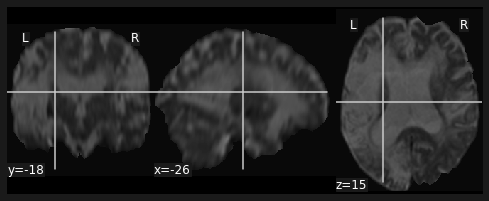

In [88]:
plotting.plot_anat('/media/harryzhang/VolumeWD/output/output_manual/570364_BET_t2_second_run_r.nii.gz')

In [73]:
# register with dwi
applyxfm = fsl.preprocess.ApplyXFM()
applyxfm.inputs.in_file = data_test_folder+'/570364/DWI_b1000.nii.gz'
applyxfm.inputs.in_matrix_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_T2_r_transform.mat'
applyxfm.inputs.out_file =  '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_DWI_ANTS.nii.gz'
applyxfm.inputs.reference = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_t2_second_run_r.nii.gz'
applyxfm.inputs.apply_xfm = True
result = applyxfm.run()

# apply skull stripping mask
am = fsl.maths.ApplyMask()
am.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_DWI_ANTS.nii.gz'
am.inputs.mask_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_t2_second_run_r_mask.nii.gz'
am.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_DWI.nii.gz'
res = am.run() 

In [74]:
# register with FLAIR
flt = fsl.FLIRT(cost_func='mutualinfo', interp='spline',
                searchr_x=[-180, 180], searchr_y=[-180, 180], searchr_z=[-180,180])
flt.inputs.in_file = data_test_folder+'/570364/FLAIR.nii.gz'
flt.inputs.reference = atlas_folder+'/mni152_2009_256.nii.gz'
flt.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_FLAIR_ANTS.nii.gz'
flt.inputs.in_matrix_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_T2_r_transform.mat'
res = flt.run()

# apply skull stripping mask
am = fsl.maths.ApplyMask()
am.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_FLAIR_ANTS.nii.gz'
am.inputs.mask_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_t2_second_run_r_mask.nii.gz'
am.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_FLAIR.nii.gz'
res = am.run() 

In [76]:
# register with ADC
reorient = fsl.utils.Reorient2Std()
reorient.inputs.in_file = data_test_folder+'/570364/ADC.nii.gz'
reorient.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/ADC_reorient.nii.gz'
res = reorient.run()


flt = fsl.FLIRT(cost_func='mutualinfo', interp='spline',
                searchr_x=[-180, 180], searchr_y=[-180, 180], searchr_z=[-180,180],dof=6)
flt.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/ADC_reorient.nii.gz'
flt.inputs.reference = '/media/harryzhang/VolumeWD/output/output_manual/570364_FLAIR.nii.gz'
flt.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_ADC_ANTS.nii.gz'
flt.inputs.in_matrix_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_T2_r_transform.mat'
flt.inputs.out_matrix_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_ADC_transform.mat'
res = flt.run()

# apply skull stripping mask
am = fsl.maths.ApplyMask()
am.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_ADC_ANTS.nii.gz'
am.inputs.mask_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_t2_second_run_r_mask.nii.gz'
am.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_ADC.nii.gz'
res = am.run()     

In [81]:
# register with TTP
reorient = fsl.utils.Reorient2Std()
reorient.inputs.in_file = data_test_folder+'/570364/TTP.nii.gz'
reorient.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_TTP_bw_reorient.nii.gz'
res = reorient.run() 

flt = fsl.FLIRT(cost_func='mutualinfo', interp='spline', 
                searchr_x=[-180, 180], searchr_y=[-180, 180], searchr_z=[-180,180],dof=6)
flt.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_TTP_bw_reorient.nii.gz'
flt.inputs.reference = '/media/harryzhang/VolumeWD/output/output_manual/570364_FLAIR.nii.gz'
flt.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_TTP_ANTS.nii.gz'
flt.inputs.in_matrix_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_T2_r_transform.mat'
res = flt.run()

# apply skull stripping mask
am = fsl.maths.ApplyMask()
am.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_TTP_ANTS.nii.gz'
am.inputs.mask_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_BET_t2_second_run_r_mask.nii.gz'
am.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/570364_TTP.nii.gz'
res = am.run() 

In [31]:
# register with TMAX
reorient = fsl.utils.Reorient2Std()
reorient.inputs.in_file = data_test_folder+'/540410/TMAX.nii.gz'
reorient.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_TMAX_bw_reorient.nii.gz'
res = reorient.run() 

flt = fsl.FLIRT(cost_func='mutualinfo', interp='spline',
                searchr_x=[-180, 180], searchr_y=[-180, 180], searchr_z=[-180,180],dof=6)
flt.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_TMAX_bw_reorient.nii.gz'
flt.inputs.reference = '/media/harryzhang/VolumeWD/output/output_manual/540410_FLAIR.nii.gz'
flt.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_TMAX_ANTS.nii.gz'
flt.inputs.in_matrix_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_T2_r_transform.mat'
res = flt.run()

# apply skull stripping mask
am = fsl.maths.ApplyMask()
am.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_TMAX_ANTS.nii.gz'
am.inputs.mask_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_t2_second_run_r_mask.nii.gz'
am.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_TMAX.nii.gz'
res = am.run()

In [10]:
btr2 = fsl.BET()
btr2.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_TTP.nii.gz'
btr2.inputs.robust = True
btr2.inputs.frac = 0.5
btr2.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_TTP.nii.gz'
res = btr2.run()

In [30]:
# register with CBF
reorient = fsl.utils.Reorient2Std()
reorient.inputs.in_file = data_test_folder+'/540410/CBF.nii.gz'
reorient.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_CBF_bw_reorient.nii.gz'
res = reorient.run() 

flt = fsl.FLIRT(cost_func='mutualinfo', interp='spline', 
                searchr_x=[-180, 180], searchr_y=[-180, 180], searchr_z=[-180,180],dof=6)
flt.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_CBF_bw_reorient.nii.gz'
flt.inputs.reference = '/media/harryzhang/VolumeWD/output/output_manual/540410_FLAIR.nii.gz'
flt.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_CBF_ANTS.nii.gz'
flt.inputs.in_matrix_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_T2_r_transform.mat'
res = flt.run()

# apply skull stripping mask
am = fsl.maths.ApplyMask()
am.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_CBF_ANTS.nii.gz'
am.inputs.mask_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_t2_second_run_r_mask.nii.gz'
am.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_CBF.nii.gz'
res = am.run() 

In [27]:
# register with CBV
reorient = fsl.utils.Reorient2Std()
reorient.inputs.in_file = data_test_folder+'/540410/CBV.nii.gz'
reorient.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_CBV_bw_reorient.nii.gz'
res = reorient.run() 

flt = fsl.FLIRT(cost_func='mutualinfo', interp='spline',
                searchr_x=[-180, 180], searchr_y=[-180, 180], searchr_z=[-180,180],dof=6)
flt.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_CBV_bw_reorient.nii.gz'
flt.inputs.reference = '/media/harryzhang/VolumeWD/output/output_manual/540410_DWI.nii.gz'
flt.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_CBV_ANTS.nii.gz'
flt.inputs.in_matrix_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_T2_r_transform.mat'
res = flt.run()

# apply skull stripping mask
am = fsl.maths.ApplyMask()
am.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_CBV_ANTS.nii.gz'
am.inputs.mask_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_t2_second_run_r_mask.nii.gz'
am.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_CBV.nii.gz'
res = am.run() 

In [32]:
# register with MTT
reorient = fsl.utils.Reorient2Std()
reorient.inputs.in_file = data_test_folder+'/540410/MTT.nii.gz'
reorient.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_MTT_bw_reorient.nii.gz'
res = reorient.run() 

flt = fsl.FLIRT(cost_func='mutualinfo', interp='spline',
                searchr_x=[-180, 180], searchr_y=[-180, 180], searchr_z=[-180,180],dof=6)
flt.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_MTT_bw_reorient.nii.gz'
flt.inputs.reference = '/media/harryzhang/VolumeWD/output/output_manual/540410_FLAIR.nii.gz'
flt.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_MTT.nii.gz'
flt.inputs.in_matrix_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_T2_r_transform.mat'
res = flt.run()

# apply skull stripping mask
am = fsl.maths.ApplyMask()
am.inputs.in_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_MTT.nii.gz'
am.inputs.mask_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_t2_second_run_r_mask.nii.gz'
am.inputs.out_file = '/media/harryzhang/VolumeWD/output/output_manual/540410_MTT.nii.gz'
res = am.run() 

In [28]:
# normalization

#dwi449 = '/media/harryzhang/VolumeWD/output/output_manual/540449_BET_DWI_ANTS.nii.gz'
#dwi449 = nib.load(dwi449)
#mask449 = '/media/harryzhang/VolumeWD/output/output_manual/540449_BET_t2_second_run_r_mask.nii.gz'
#mask449 = nib.load(mask449)
dwi410 = '/media/harryzhang/VolumeWD/output/output_manual/540410_DWI.nii.gz'
dwi410 = nib.load(dwi410)
mask410 = '/media/harryzhang/VolumeWD/output/output_manual/540410_BET_t2_second_run_r_mask.nii.gz'
mask410 = nib.load(mask410)

#norm_DWI449 = zscore.zscore_normalize(dwi449,mask449)
norm_DWI410 = zscore.zscore_normalize(dwi410,mask410)

#nib.save(norm_DWI449,'/media/harryzhang/VolumeWD/output/output_manual/dwi449_norm.nii.gz')
nib.save(norm_DWI410,'/media/harryzhang/VolumeWD/output/output_manual/dwi410_norm.nii.gz')

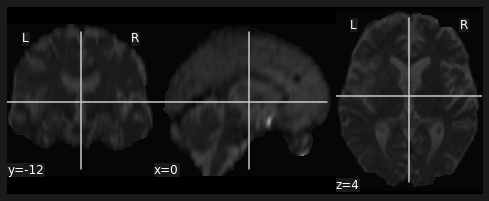

In [11]:
plotting.plot_anat(norm_DWI449)

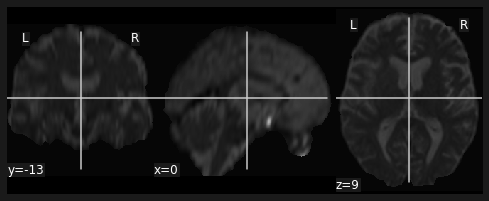

In [12]:
plotting.plot_anat(dwi449)

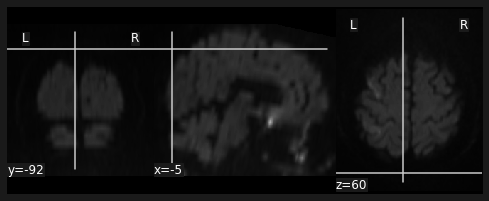

In [25]:
plotting.plot_anat(norm_DWI410)

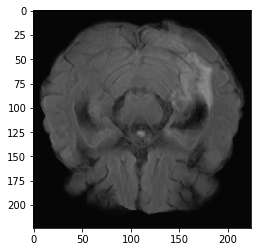

In [108]:
import numpy as np
from matplotlib import pyplot as plt

img_array_1 = np.load('/media/harryzhang/New Volume/540402.npy')
img_array_2 = np.load('/media/harryzhang/New Volume/540402_aug.npy')

plt.imshow(img_array[1,6,:,:,:])
plt.show()

In [104]:

# Normalised [0,255] as integer
c = (255*img_array_1).astype(int)

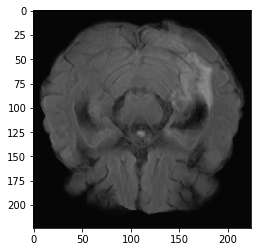

In [203]:
plt.imshow(c[1,6,:,:,:])
plt.show()

ValueError: num must be 1 <= num <= 20, not 21

<Figure size 432x288 with 0 Axes>

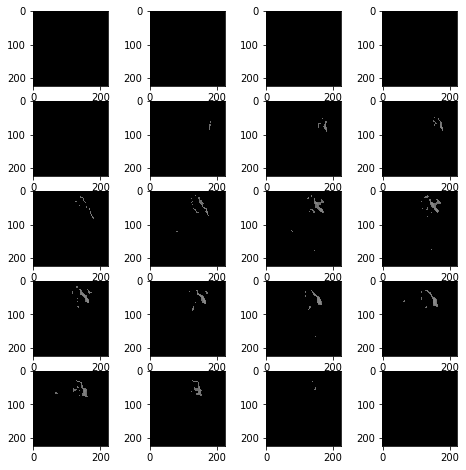

In [222]:
import cv2

a = img_array*(img_array>0.42)

fig = plt.figure()
columns = 4
rows = 5
fig=plt.figure(figsize=(8, 8))

for i,value in enumerate(a[1,:,:,:,:]):
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(value,kernel,iterations =2)
    dilation = cv2.dilate(value, kernel, iterations=2) 
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(erosion)

plt.show()

In [230]:
sub = img_array_1[1,15,:,0:112,:] - img_array_1[1,15,:,112:,:]

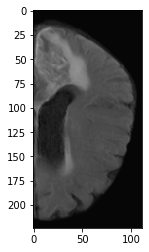

In [228]:
plt.imshow(img_array_1[1,15,:,112:,:])

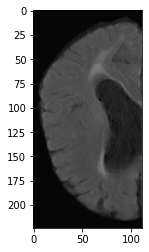

In [229]:
plt.imshow(img_array_1[1,15,:,0:112,:])

In [169]:
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


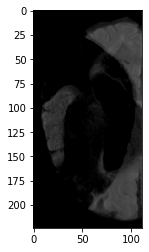

In [231]:
plt.imshow(sub)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


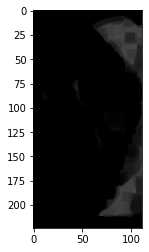

In [224]:
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(sub,kernel,iterations =2)
dilation = cv2.dilate(sub, kernel, iterations=2) 

plt.imshow(erosion)
plt.show()